In [87]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D

data = pd.read_csv("survey_answers.csv", index_col=0)

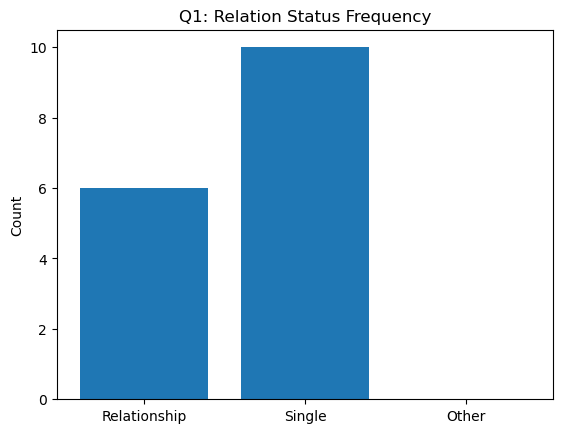

In [88]:
def plotGroupedResponses(question, 
                         group_labels, 
                         title):

    categories = [1, 2, 3]
    labels = group_labels
    
    counts = data[question].value_counts().reindex(categories, fill_value=0)
    
    plt.bar(counts.index, counts.values)
    
    plt.title(title)
    plt.ylabel("Count")
    
    plt.xticks(counts.index, labels)
    
    plt.show()

plotGroupedResponses(question = "Q1",
                     group_labels = ['Relationship', 'Single', 'Other'], 
                     title = "Q1: Relation Status Frequency")

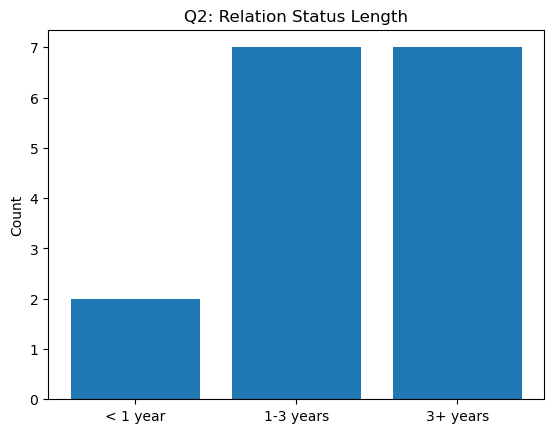

In [89]:
plotGroupedResponses(question = "Q2",
                     group_labels = ['< 1 year', '1-3 years', '3+ years'], 
                     title = "Q2: Relation Status Length")

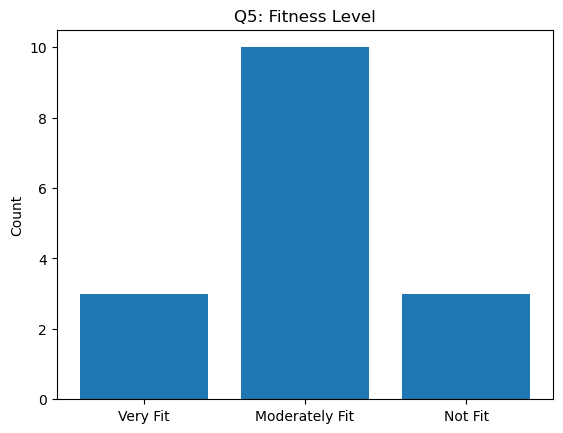

In [90]:
plotGroupedResponses(question = "Q5",
                     group_labels = ['Very Fit', 'Moderately Fit', 'Not Fit'], 
                     title = "Q5: Fitness Level")

    relationship  single     ratio
Q5                                
1              2       1  0.666667
2              4       6  0.400000
3              0       3  0.000000


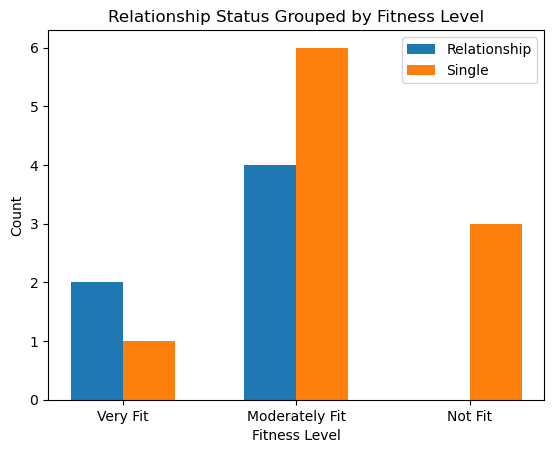

In [112]:
fit_by_relationship = data.groupby("Q5").agg(
    relationship = ("Q1", lambda x: (x == 1).sum()),
    single = ("Q1", lambda x: (x == 2).sum())
)

fit_by_relationship["ratio"] = fit_by_relationship.relationship/(fit_by_relationship.relationship + fit_by_relationship.single)

print(fit_by_relationship)

x = np.arange(len(fit_by_relationship))
width = 0.3

fig, ax = plt.subplots()

ax.bar(x - width/2, fit_by_relationship["relationship"], width, label="Relationship")
ax.bar(x + width/2, fit_by_relationship["single"], width, label="Single")

ax.set_title("Relationship Status Grouped by Fitness Level")
ax.set_xlabel("Fitness Level")
ax.set_ylabel("Count")
ax.legend()

ax.set_xticks(x)
ax.set_xticklabels(['Very Fit', 'Moderately Fit', 'Not Fit'])

plt.show()

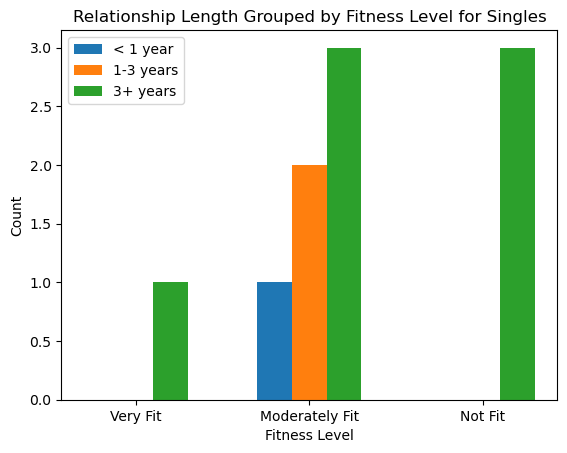

In [148]:
singles = data.query("Q1 == 2")

fit_by_single_len = singles.groupby("Q5").agg(
    less_than_one = ("Q2", lambda x: (x == 1).sum()),
    one_to_three = ("Q2", lambda x: (x == 2).sum()),
    more_than_three = ("Q2", lambda x: (x == 3).sum())
)

x = np.arange(len(fit_by_relationship))
width = 0.2

fig, ax = plt.subplots()

ax.bar(x - width, fit_by_single_len["less_than_one"], width, label="< 1 year")
ax.bar(x, fit_by_single_len["one_to_three"], width, label="1-3 years")
ax.bar(x + width, fit_by_single_len["more_than_three"], width, label="3+ years")

ax.set_title("Relationship Length Grouped by Fitness Level for Singles")
ax.set_xlabel("Fitness Level")
ax.set_ylabel("Count")
ax.legend()

ax.set_xticks(x)
ax.set_xticklabels(['Very Fit', 'Moderately Fit', 'Not Fit'])

plt.show()

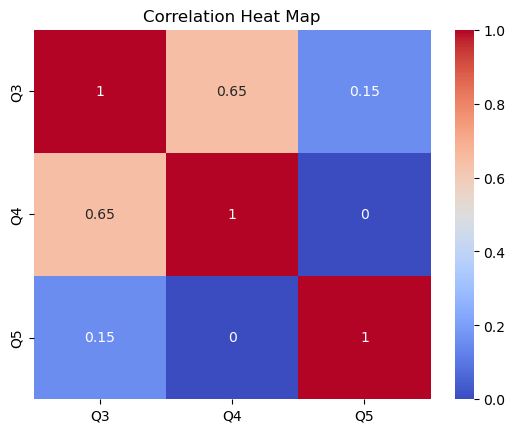

In [171]:
## import seaborn as sns
import matplotlib.pyplot as plt

corr = data[['Q3', 'Q4', 'Q5']].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")

plt.title("Correlation Heat Map")
plt.show()

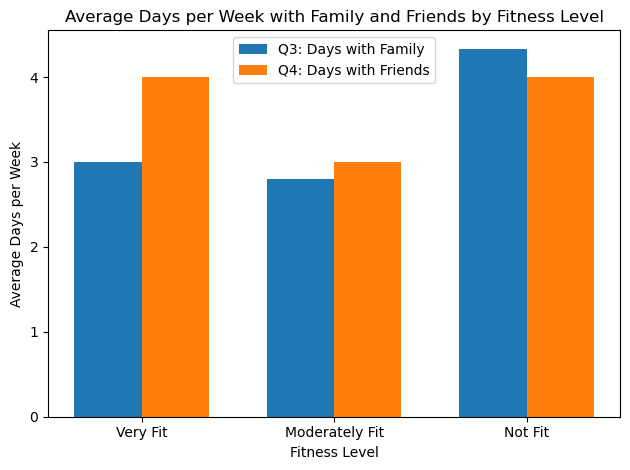

In [147]:
Q3_by_Q5 = data.groupby("Q5")["Q3"].mean().reset_index(name="Q3_avg")
Q4_by_Q5 = data.groupby("Q5")["Q4"].mean().reset_index(name="Q4_avg")

merged = Q3_by_Q5.merge(Q4_by_Q5, on="Q5")

x = np.arange(len(merged))
width = 0.35

fig, ax = plt.subplots()

ax.bar(x - width/2, merged["Q3_avg"], width, label="Q3: Days with Family")
ax.bar(x + width/2, merged["Q4_avg"], width, label="Q4: Days with Friends")

ax.set_xticks(x)
ax.set_xticklabels(['Very Fit', 'Moderately Fit', 'Not Fit'])
ax.set_xlabel("Fitness Level")
ax.set_ylabel("Average Days per Week")
ax.set_title("Average Days per Week with Family and Friends by Fitness Level")
ax.legend()

plt.tight_layout()
plt.show()


In [222]:
from scipy import stats

def getInfoGroupedByFitness(question):

    info = data.groupby("Q5")[question].agg(
        mean="mean",
        sd="std",
        count="count"
    ).reset_index()
    
    confidence = 0.95
    alpha = 1 - confidence
    t_multiplier = stats.t.ppf(1 - alpha/2, df=info["count"] - 1)
    
    info["lower95"] = info["mean"] - t_multiplier * (info["sd"] / np.sqrt(info["count"]))
    info["upper95"] = info["mean"] + t_multiplier * (info["sd"] / np.sqrt(info["count"]))

    return info

Q3_by_Q5 = getInfoGroupedByFitness("Q3")
Q4_by_Q5 = getInfoGroupedByFitness("Q4")

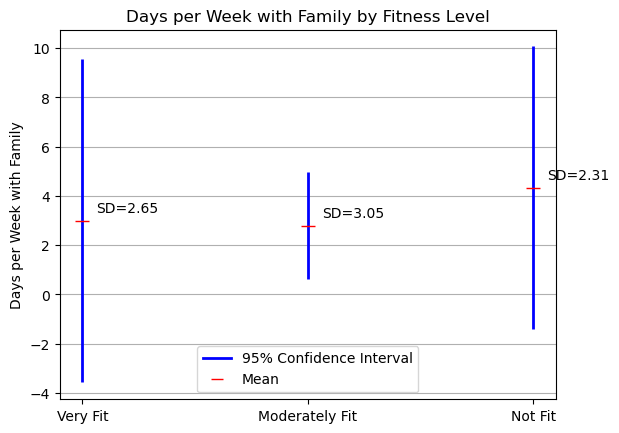

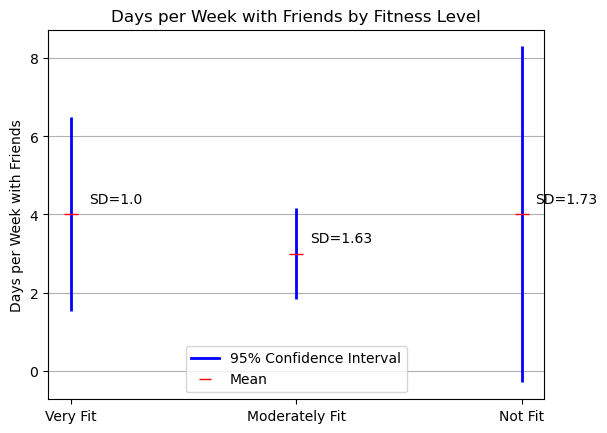

In [221]:
def plot95CI(Q5_stats, relationship_type):
    
    fig, ax = plt.subplots()
    
    for i, row in Q5_stats.iterrows():
        ax.vlines(x=row.Q5, ymin=row.lower95, ymax=row.upper95, color='b', lw=2)
        ax.plot(row.Q5, row["mean"], '_', color='r', markersize=10)
        ax.text(row.Q5 + 0.2, row["mean"] + 0.2, f"SD={row.sd.round(2)}", ha='center', va='bottom', fontsize=10)
    
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['Very Fit', 'Moderately Fit', 'Not Fit'])
    
    ax.set_title(f"Days per Week with {relationship_type} by Fitness Level")
    ax.set_ylabel(f"Days per Week with {relationship_type}")
    
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='95% Confidence Interval'),
        Line2D([0], [0], marker='_', color='r', label='Mean', markersize=8, linestyle='None')
    ]
    ax.legend(handles=legend_elements, loc=8)
    
    plt.grid(axis='y')
    plt.show()

plot95CI(Q3_by_Q5, 'Family')
plot95CI(Q4_by_Q5, 'Friends')